In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsTh_0002.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.88419969, 4.00877097)>


In [3]:
x = [101.812093,101.806429,101.797486,101.771853,101.819136,101.810250,101.818790,101.818916,101.807737,101.788950]
y = [3.974229,3.963025,3.990697,3.942408,3.975548,3.939188,3.986519,3.946385,3.9309082,4.006325]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1V Reduced')
file = 'reduceducdTh_0002.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -10<(k-xref)<10 and -10<(l-yref)<10:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[512.20284616 544.05191711 596.7590672  741.03307346 471.92652481
 520.88961244 474.49511861 471.62780509 534.84433229 646.49000878]
[303.42164306 368.06514527 209.69335864 488.36991844 295.45320623
 504.70616751 232.48484992 462.89917109 552.38413093 120.44644541]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
246 512.10829 297.64351 0.93044968 ...   0 3545.1052 136.15988 -5.3351229
255 516.27558 308.75905 0.95390541 ...   0 183.40881 6.8815388 -2.0942139
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
294 541.18262 367.40715 0.80348529 ...   0 356.58896 15.331443 -2.9639576
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
168 596.31494 208.36926 0.88450919 ...   0 487.26843 19.312312 -3.21

In [4]:
positions = [(512.10829,297.64351),(541.18262,367.40715),(596.31494,208.36926),(739.58812,486.86035),
             (470.39312,294.11869),(520.16364,503.59666),(473.07876,231.15333),(472.46078,463.1387),
             (532.68462,549.81512),(647.93217,120.17911)]

In [5]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=3) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.41512431 -16.4050472 ]
[[ 0.00036859 -0.00516539]
 [-0.00516539  0.07271705]]
Beta: [  0.42902437 -16.58400273]
Beta Std Error: [0.02091875 0.29025647]
Beta Covariance: [[ 6.44904794e-05 -8.93262880e-04]
 [-8.93262880e-04  1.24161830e-02]]
Residual Variance: 6.785404197589709
Inverse Condition #: 0.02277910717202123
Reason(s) for Halting:
  Sum of squares convergence


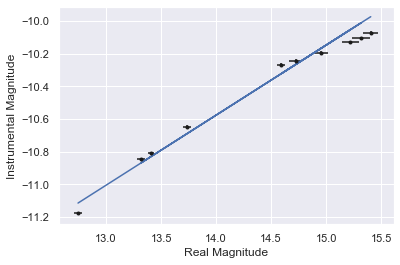

In [6]:
mags = np.array(mags)
realmag = [12.746,15.219,14.957,13.739,13.407,13.321,14.724,15.319,14.591,15.406]
realmag = np.array(realmag)
realmagerrors = [0.037,0.078,0.061,0.037,0.027,0.037,0.06,0.082,0.039,0.069]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [7]:
xref = 642
yref = 345

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
 93 647.93217 120.17911 0.91497182 ...   0 296.02331 11.407022 -2.6429307
279 642.07928 344.34946 0.90180393 ...   0 28503.501 1114.8142 -7.6180062


In [14]:
sourcemag = []
sourcemagerror = []
position = [(642.07928,344.34946)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-13.172213993704611]


In [15]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.952435673328976 +/- 0.7798115002163409
